In [2]:
from google.colab import files
uploaded = files.upload()


Saving tab_aml_polars_version_fourtysix.py to tab_aml_polars_version_fourtysix (1).py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [8]:
import os, sys



In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import polars as pl

df = pl.read_csv("/content/drive/MyDrive/AML_Data/SAML-D.csv")
df.head()


Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
str,str,i64,i64,f64,str,str,str,str,str,i64,str
"""10:35:19""","""2022-10-07""",8724731955,2769355426,1459.15,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,"""Normal_Cash_Deposits"""
"""10:35:20""","""2022-10-07""",1491989064,8401255335,6019.64,"""UK pounds""","""Dirham""","""UK""","""UAE""","""Cross-border""",0,"""Normal_Fan_Out"""
"""10:35:20""","""2022-10-07""",287305149,4404767002,14328.44,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cheque""",0,"""Normal_Small_Fan_Out"""
"""10:35:21""","""2022-10-07""",5376652437,9600420220,11895.0,"""UK pounds""","""UK pounds""","""UK""","""UK""","""ACH""",0,"""Normal_Fan_In"""
"""10:35:21""","""2022-10-07""",9614186178,3803336972,115.25,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,"""Normal_Cash_Deposits"""


In [5]:
from datetime import timedelta
import os

In [6]:
drive_path = '/content/drive/MyDrive/Colab Notebooks/'

In [7]:
df_train = pl.read_parquet(os.path.join(drive_path, "df_train.parquet"))
df_val = pl.read_parquet(os.path.join(drive_path, "df_val.parquet"))

In [9]:
df_test = pl.read_parquet(os.path.join(drive_path, "df_test.parquet"))

In [10]:
import torch
from tab_aml_polars_version_fourtysix import  FocalLoss, fast_hash, collate_encoded_batch, TabAMLDataset, TabAMLModel, train_epoch, evaluate, compute_pos_weight, build_weighted_sampler
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
import torch.nn as nn

In [11]:
print(df_train)

shape: (7_429_619, 39)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Time     ┆ Date      ┆ Sender_ac ┆ Receiver_ ┆ … ┆ weekly_re ┆ daily_sen ┆ weekly_se ┆ circular_ │
│ ---      ┆ ---       ┆ count     ┆ account   ┆   ┆ ceiver_tr ┆ der_trans ┆ nder_tran ┆ transacti │
│ time     ┆ date      ┆ ---       ┆ ---       ┆   ┆ ansaction ┆ action    ┆ saction   ┆ on_count  │
│          ┆           ┆ i64       ┆ i64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│          ┆           ┆           ┆           ┆   ┆ i16       ┆ i16       ┆ i16       ┆ i8        │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 10:35:34 ┆ 2022-10-0 ┆ 560602477 ┆ 864619375 ┆ … ┆ 1         ┆ 1         ┆ 1         ┆ 0         │
│          ┆ 7         ┆ 5         ┆ 9         ┆   ┆           ┆           ┆           ┆           │
│ 10:36:04 ┆ 2022-10-0 ┆ 200413348 ┆ 307981854 ┆ … ┆ 68        ┆ 11 

In [12]:
df_train = df_train.with_columns(
    (df_train["Date"].dt.weekday().is_in([5, 6])).cast(pl.Int8).alias("is_weekend")
)


In [13]:
df_val = df_val.with_columns([
    (df_val["Date"].dt.weekday().is_in([5, 6])).cast(pl.Int8).alias("is_weekend")
])


In [14]:
df_test = df_test.with_columns(
    (df_test["Date"].dt.weekday().is_in([5, 6])).cast(pl.Int8).alias("is_weekend")
)


In [15]:
print(len(df_train), len(df_val), len(df_test))

7429619 1044845 1030388


In [16]:
cat_cols = ["Sender_account", "currency_mismatch",	"cross_border",	"high_risk_sender",	"high_risk_receiver"	, "Receiver_account", "Payment_currency", "Received_currency", "Sender_bank_location",
            "Receiver_bank_location", "Payment_type", "day_of_month", "month", "day_of_week", "minute", "second", "hour", "day_of_year", "is_weekend"]

In [17]:
cont_cols = ["Amount", "fanin_30d",	"fanout_30d",	"daily_recieve",	"monthly_receive",	"monthly_send", "back_and_forth_transfers",	"daily_receive",	"amount_dispersion_std",	"fan_in_out_ratio"	,"fanin_intensity_ratio",	"sent_to_received_ratio_monthly"	,"daily_receiver_transaction",	"weekly_receiver_transaction",	"daily_sender_transaction",	"weekly_sender_transaction",	"circular_transaction_count"]

In [18]:
train_ds = TabAMLDataset(
    df_train, cat_cols, cont_cols, "Is_laundering",
    fit=True,
    hash_growth=1.25,
    hash_cap={"Sender_account": 262_144, "Receiver_account": 1_048_576}
)


In [19]:
val_ds = TabAMLDataset(
    df_val, cat_cols, cont_cols, "Is_laundering",
    encoders=train_ds.encoders,
    scaler=train_ds.scaler,
    fit=False,
    hash_bucket_sizes=train_ds.hash_bucket_sizes
)

In [20]:
test_ds = TabAMLDataset(
    df_test, cat_cols, cont_cols, "Is_laundering",
    encoders=train_ds.encoders,
    scaler=train_ds.scaler,
    fit=False,
    hash_bucket_sizes=train_ds.hash_bucket_sizes
)

In [21]:
print("Hash bucket sizes:", train_ds.hash_bucket_sizes)

Hash bucket sizes: {'Receiver_account': 1048576, 'Sender_account': 262144}


In [22]:
print("Unique Sender accounts:", df_train["Sender_account"].n_unique())
print("Unique Receiver accounts:", df_train["Receiver_account"].n_unique())

Unique Sender accounts: 245891
Unique Receiver accounts: 589380


In [23]:
train_sampler = build_weighted_sampler(pl.Series(df_train["Is_laundering"]), power = 0.7)

In [24]:
train_loader  = DataLoader(train_ds, batch_size=512, sampler=train_sampler, collate_fn=collate_encoded_batch)


In [25]:
val_loader   = DataLoader(val_ds, batch_size=512, shuffle=False, collate_fn=collate_encoded_batch)

In [26]:
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False, collate_fn=collate_encoded_batch)

In [27]:
model = TabAMLModel(category_sizes=train_ds.category_sizes, cont_dim=len(cont_cols), embedding_dim=48, shared_ratio=1/6, num_heads=4, num_layers1=2, num_layers2=2, dropout=0.25, micro_indices=(0, 1))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TabAMLModel(
  (embs): ModuleList(
    (0): Embedding(262144, 40)
    (1-4): 4 x Embedding(3, 40)
    (5): Embedding(1048576, 40)
    (6-7): 2 x Embedding(14, 40)
    (8-9): 2 x Embedding(19, 40)
    (10): Embedding(8, 40)
    (11): Embedding(32, 40)
    (12): Embedding(10, 40)
    (13): Embedding(8, 40)
    (14-15): 2 x Embedding(61, 40)
    (16): Embedding(25, 40)
    (17): Embedding(251, 40)
    (18): Embedding(3, 40)
  )
  (micro): ResidualAttentionEncoder(
    (layers): ModuleList(
      (0-1): 2 x ResidualAttentionLayer(
        (qkv): Linear(in_features=48, out_features=144, bias=False)
        (attn_out): Linear(in_features=48, out_features=48, bias=False)
        (ffn): Sequential(
          (0): Linear(in_features=48, out_features=192, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.25, inplace=False)
          (3): Linear(in_features=192, out_features=48, bias=True)
          (4): Dropout(p=0.25, inplace=False)
        )
        (norm1): LayerNo

In [28]:
loss_fn = FocalLoss(alpha=0.75, gamma=2.0)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2,  min_lr=1e-6
)

In [29]:
epochs = 20
best_val_auc_pr = 0

for epoch in range(1, epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)

    val_loss, val_auc, val_auc_pr, val_rec, val_prec, val_f1, _ = evaluate(
        model, val_loader, loss_fn, device
    )

    scheduler.step(val_auc_pr)

    print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | ROC-AUC: {val_auc:.4f} | "
          f"PR-AUC: {val_auc_pr:.4f} | Recall: {val_rec:.3f} | "
          f"Precision: {val_prec:.3f} | F1: {val_f1:.3f}")

    # Keep best model
    if val_auc_pr > best_val_auc_pr:
        best_val_auc_pr = val_auc_pr
        torch.save(model.state_dict(), "best_tabaml_model.pt")
        print(f" Saved new best model (PR-AUC = {best_val_auc_pr:.4f})")


Epoch 1/20 | Train Loss: 0.0050 | Val Loss: 0.0015 | ROC-AUC: 0.9656 | PR-AUC: 0.5803 | Recall: 0.651 | Precision: 0.212 | F1: 0.320
 Saved new best model (PR-AUC = 0.5803)
Epoch 2/20 | Train Loss: 0.0017 | Val Loss: 0.0017 | ROC-AUC: 0.9710 | PR-AUC: 0.6431 | Recall: 0.605 | Precision: 0.690 | F1: 0.644
 Saved new best model (PR-AUC = 0.6431)
Epoch 3/20 | Train Loss: 0.0012 | Val Loss: 0.0018 | ROC-AUC: 0.9703 | PR-AUC: 0.6644 | Recall: 0.610 | Precision: 0.744 | F1: 0.670
 Saved new best model (PR-AUC = 0.6644)
Epoch 4/20 | Train Loss: 0.0010 | Val Loss: 0.0017 | ROC-AUC: 0.9704 | PR-AUC: 0.6744 | Recall: 0.620 | Precision: 0.741 | F1: 0.675
 Saved new best model (PR-AUC = 0.6744)
Epoch 5/20 | Train Loss: 0.0008 | Val Loss: 0.0027 | ROC-AUC: 0.9665 | PR-AUC: 0.6738 | Recall: 0.564 | Precision: 0.964 | F1: 0.711
Epoch 6/20 | Train Loss: 0.0008 | Val Loss: 0.0023 | ROC-AUC: 0.9697 | PR-AUC: 0.6874 | Recall: 0.569 | Precision: 0.955 | F1: 0.713
 Saved new best model (PR-AUC = 0.6874)
Ep

In [30]:
@torch.no_grad()
def pick_threshold_by(val_loader, model, device, criterion="f1", min_precision=None):
    """
    Determine best probability threshold using validation set.

    """
    model.eval()
    y_all, p_all = [], []

    for batch in val_loader:
        x_cat = batch.x_cat.to(device)
        x_cont = batch.x_cont.to(device)
        y = batch.y.to(device)
        p = torch.sigmoid(model(x_cat, x_cont)).cpu().numpy()
        y_all.extend(y.cpu().numpy())
        p_all.extend(p)

    y_all = np.array(y_all)
    p_all = np.array(p_all)

    prec, rec, thr = precision_recall_curve(y_all, p_all)

    if criterion == "f1":
        f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
        best_idx = np.argmax(f1)

    elif criterion == "recall_at_precision":
        assert min_precision is not None, "min_precision must be given"
        valid = np.where(prec >= min_precision)[0]
        best_idx = valid[np.argmax(rec[valid])] if len(valid) else np.argmax(rec)

    else:
        raise ValueError("criterion must be 'f1' or 'recall_at_precision'")

    # threshold array is one shorter than prec/rec vectors → align index
    best_thr = thr[max(best_idx - 1, 0)]
    return float(best_thr), float(prec[best_idx]), float(rec[best_idx])


In [31]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc as auc_metric,
    recall_score, precision_score, f1_score, confusion_matrix,
)


In [36]:
model.load_state_dict(torch.load("best_tabaml_model.pt"))

best_thr, best_prec, best_rec = pick_threshold_by(
    val_loader,
    model,
    device,
    criterion="recall_at_precision",
    min_precision=0.40
)

print(f"Best threshold: {best_thr:.3f} | Precision: {best_prec:.3f} | Recall: {best_rec:.3f}")


Best threshold: 0.031 | Precision: 0.400 | Recall: 0.698


In [37]:
test_loss, test_auc, test_pr, test_rec, test_prec, test_f1, cm = evaluate(
    model, test_loader, loss_fn, device, threshold=best_thr
)

print("\n FINAL TEST RESULTS")
print(f"Loss: {test_loss:.4f} | ROC-AUC: {test_auc:.4f} | PR-AUC: {test_pr:.4f}")
print(f"Recall: {test_rec:.3f} | Precision: {test_prec:.3f} | F1: {test_f1:.3f}")
print(f"Confusion Matrix: {cm}")



 FINAL TEST RESULTS
Loss: 0.0029 | ROC-AUC: 0.9578 | PR-AUC: 0.6323
Recall: 0.644 | Precision: 0.372 | F1: 0.472
Confusion Matrix: (1027889, 1301, 426, 772)


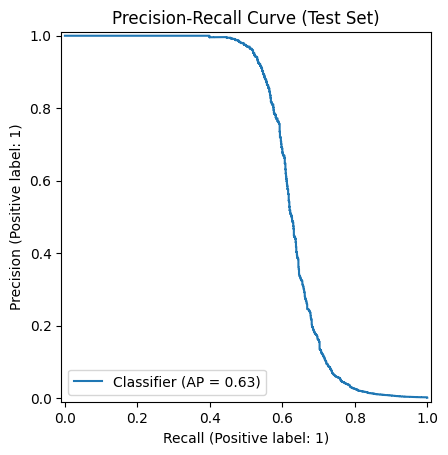

In [38]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        logits = model(batch.x_cat.to(device), batch.x_cont.to(device))
        y_true.extend(batch.y.numpy())
        y_pred.extend(torch.sigmoid(logits).cpu().numpy())

disp = PrecisionRecallDisplay.from_predictions(y_true, y_pred)
disp.ax_.set_title("Precision-Recall Curve (Test Set)")
plt.show()


In [40]:
# Convert display to numpy (works in Colab / any backend)
fig = disp.figure_
fig.canvas.draw()

# Extract RGBA buffer and convert to numpy
img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # (H, W, 4) RGBA

# If you want to drop alpha and keep only RGB:
img = img[:, :, :3]


In [41]:
np.save("pr_curve.npy", img)

In [42]:
from google.colab import files
files.download("pr_curve.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>